<a href="https://colab.research.google.com/github/daisea3e1203/soco_fashion_dnn/blob/main/02_clustering_32_heatmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 31.3 MB/s 


In [ ]:
from collections import defaultdict
import random
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tqdm import tqdm

# Config

In [ ]:
target_size = 32  # Resize the input images.
representation_dim = 512  # The dimensions of the features vector.
projection_units = 128  # The projection head of the representation learner.
num_clusters = 20  # Number of clusters.
k_neighbours = 5  # Number of neighbours to consider during cluster learning.
tune_encoder_during_clustering = False  # Freeze the encoder in the cluster learning.

# Load data

In [ ]:
num_classes = 10
input_shape = (32, 32, 3)

dataset = keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Soco/Fashion/dataset/襤褸 機械学習',
    image_size=(input_shape[0], input_shape[1]),
    batch_size=None
)

Found 341 files belonging to 4 classes.


In [ ]:
# ? throwaway labels
dataset = dataset.map(lambda x, y: x)

In [ ]:
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

In [ ]:
data_preprocessing = keras.Sequential(
    [
        layers.Resizing(target_size, target_size),
        layers.Normalization(),
    ]
)
# Compute the mean and the variance from the data for normalization.
data_preprocessing.layers[-1].adapt(dataset)

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomTranslation(
            height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode="nearest"
        ),
        layers.RandomFlip(mode="horizontal"),
        layers.RandomRotation(
            factor=0.15, fill_mode="nearest"
        ),
        layers.RandomZoom(
            height_factor=(-0.3, 0.1), width_factor=(-0.3, 0.1), fill_mode="nearest"
        )
    ]
)

(32, 32, 3)


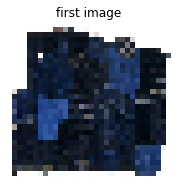

In [ ]:
# Show a single image from the dataset
for d in dataset:
    image = d
    plt.figure(figsize=(3, 3))
    image_np = image.numpy()
    print(image_np.shape)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("first image")
    _ = plt.axis("off")
    break

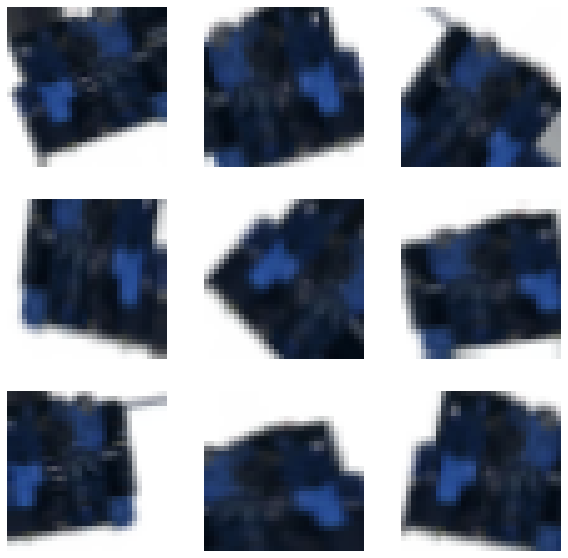

In [ ]:
# Plot a couple augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_images = data_augmentation(image.numpy())
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images.numpy().astype("uint8"))
    plt.axis("off")

# Define model

implement vision encoder

In [ ]:
def create_encoder(representation_dim):
    inputs = keras.Input(shape=(32,32,3))
    x = keras.applications.ResNet50V2(input_tensor=inputs, include_top=False, weights=None, pooling="avg")
    x = layers.Dense(representation_dim)(x.output)
    encoder = keras.Model(inputs, x)
    
    return encoder

implement unsupervised contrastive loss

In [ ]:
class RepresentationLearner(keras.Model):
    def __init__(
        self,
        encoder,
        projection_units,
        num_augmentations,
        temperature=1.0,
        dropout_rate=0.1,
        l2_normalize=False,
        **kwargs
    ):
        super(RepresentationLearner, self).__init__(**kwargs)
        self.encoder = encoder
        # Create projection head.
        self.projector = keras.Sequential(
            [
                layers.Dropout(dropout_rate),
                layers.Dense(units=projection_units, use_bias=False),
                layers.BatchNormalization(),
                layers.ReLU(),
            ]
        )
        self.num_augmentations = num_augmentations
        self.temperature = temperature
        self.l2_normalize = l2_normalize
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def compute_contrastive_loss(self, feature_vectors, batch_size):
        num_augmentations = tf.shape(feature_vectors)[0] // batch_size
        if self.l2_normalize:
            feature_vectors = tf.math.l2_normalize(feature_vectors, -1)
        # The logits shape is [num_augmentations * batch_size, num_augmentations * batch_size].
        logits = (
            tf.linalg.matmul(feature_vectors, feature_vectors, transpose_b=True)
            / self.temperature
        )
        # Apply log-max trick for numerical stability.
        logits_max = tf.math.reduce_max(logits, axis=1)
        logits = logits - logits_max
        # The shape of targets is [num_augmentations * batch_size, num_augmentations * batch_size].
        # targets is a matrix consits of num_augmentations submatrices of shape [batch_size * batch_size].
        # Each [batch_size * batch_size] submatrix is an identity matrix (diagonal entries are ones).
        targets = tf.tile(tf.eye(batch_size), [num_augmentations, num_augmentations])
        # Compute cross entropy loss
        return keras.losses.categorical_crossentropy(
            y_true=targets, y_pred=logits, from_logits=True
        )

    def call(self, inputs):
        # Preprocess the input images.
        preprocessed = data_preprocessing(inputs)
        # Create augmented versions of the images.
        augmented = []
        for _ in range(self.num_augmentations):
            augmented.append(data_augmentation(preprocessed))
        augmented = layers.Concatenate(axis=0)(augmented)
        # Generate embedding representations of the images.
        features = self.encoder(augmented)
        # Apply projection head.
        return self.projector(features)

    def train_step(self, inputs):
        batch_size = tf.shape(inputs)[0]
        # Run the forward pass and compute the contrastive loss
        with tf.GradientTape() as tape:
            feature_vectors = self(inputs, training=True)
            loss = self.compute_contrastive_loss(feature_vectors, batch_size)
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update loss tracker metric
        self.loss_tracker.update_state(loss)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, inputs):
        batch_size = tf.shape(inputs)[0]
        feature_vectors = self(inputs, training=False)
        loss = self.compute_contrastive_loss(feature_vectors, batch_size)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    
    def model(self):
        x = keras.layers.Input(shape=(32,32,3))
        return keras.Model(inputs=[x], outputs=self.call(x))

In [ ]:
dataset_np = np.stack(list(dataset))

train the model

In [ ]:
# Create vision encoder.
encoder = create_encoder(representation_dim)
# Create representation learner.
representation_learner = RepresentationLearner(
    encoder, projection_units, num_augmentations=2, temperature=0.1
)
# inputs = keras.Input(shape=(32,32,3))
# outputs = _representation_learner(inputs)
# representation_learner = tf.keras.Model(inputs=inputs, outputs=outputs)
# Create a a Cosine decay learning rate scheduler.
lr_scheduler = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001, decay_steps=500, alpha=0.1
)
# Compile the model.
representation_learner.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=lr_scheduler, weight_decay=0.0001),
)
# Fit the model.
history = representation_learner.fit(
    x=dataset_np,
    batch_size=16,
    epochs=50,  # for better results, increase the number of epochs to 500.
)

Epoch 1/50


22/22 [==============================] - 25s 102ms/step - loss: 117.2442
Epoch 2/50
22/22 [==============================] - 1s 45ms/step - loss: 12.5363
Epoch 3/50
22/22 [==============================] - 1s 45ms/step - loss: 10.1733
Epoch 4/50
22/22 [==============================] - 1s 45ms/step - loss: 9.1480
Epoch 5/50
22/22 [==============================] - 1s 46ms/step - loss: 7.3318
Epoch 6/50
22/22 [==============================] - 1s 45ms/step - loss: 7.5444
Epoch 7/50
22/22 [==============================] - 1s 45ms/step - loss: 6.7766
Epoch 8/50
22/22 [==============================] - 1s 45ms/step - loss: 6.6653
Epoch 9/50
22/22 [==============================] - 1s 45ms/step - loss: 5.9863
Epoch 10/50
22/22 [==============================] - 1s 46ms/step - loss: 6.3219
Epoch 11/50
22/22 [==============================] - 1s 46ms/step - loss: 6.0352
Epoch 12/50
22/22 [==============================] - 1s 46ms/step - loss: 6.1737
Epoch 13/50
22/22 [=======================

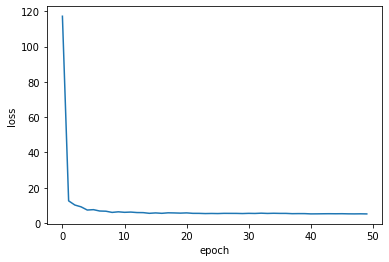

In [ ]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

# Save and verify model

In [ ]:
representation_learner.save_weights('/content/drive/MyDrive/Soco/Fashion/models/representation_learner_20220620/model.weights')

In [ ]:
encoder.save_weights('/content/drive/MyDrive/Soco/Fashion/models/encoder_20220620/model.weights')

In [ ]:
# representation_learner.load_weights('/content/drive/MyDrive/Soco/Fashion/models/representation_learner_20220620/model.weights')
# encoder.load_weights('/content/drive/MyDrive/Soco/Fashion/models/encoder_20220620/model.weights')

In [ ]:
# check weight shape
# representation_learner(dataset_np[0].reshape(1, 32, 32, 3))

In [ ]:
representation_learner.summary()

Model: "representation_learner"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 512)               24613888  
                                                                 
 sequential_2 (Sequential)   (None, 128)               66048     
                                                                 
Total params: 24,679,938
Trainable params: 24,634,240
Non-trainable params: 45,698
_________________________________________________________________


In [ ]:
# Search for last conv layer -> probably "post_relu"
representation_learner.encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 18, 18, 64)   0           ['conv1_conv[0][0]']             
                                                                                              

## Define Grad CAM

In [ ]:
from keras.layers import Input

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions

    m = model
    
    grad_model = tf.keras.models.Model(
        [m.inputs], 
        [
            m.get_layer(last_conv_layer_name).output,
            m.outputs
        ]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            # ? if pred_index is not specified, get the index of the channel with the highest activation
            pred_index = tf.argmax(preds[0][0])
        class_channel = preds[0][0][pred_index]
        
        print("class_channel")
        print(class_channel)
        print("preds")
        print(len(preds))
        print(len(preds[0]))
        print(len(preds[0][0]))

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # print("grads")
    # print(grads)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # print("pooled")
    # print(pooled_grads)

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation

    # print(last_conv_layer_output.shape)
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
# create heat map for a single image

img = dataset_np[0].reshape(1, 32, 32, 3)
heatmap = make_gradcam_heatmap(img, encoder, "conv2_block3_1_relu") # this isn't the last conv layer, but it had a nice response
# make_gradcam_heatmap(dataset_np[0].reshape(1, 32, 32, 3), representation_learner, "post_relu")

class_channel
tf.Tensor(43685.63, shape=(), dtype=float32)
preds
1
1
512


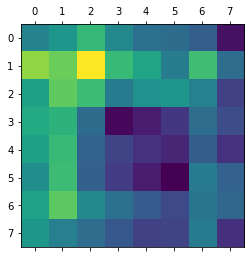

In [ ]:
plt.matshow(heatmap)
plt.show()

In [ ]:
import numpy as np
import matplotlib.cm as cm

def display_image(img_array, heatmap_array, alpha=0.4):
    heatmap = np.uint8(255 * heatmap_array)
    
    jet = cm.get_cmap("jet")
    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_array.shape[1], img_array.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    
    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img_array
    # superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    

    plt.matshow(jet_heatmap/255)
    plt.matshow(img_array/255)
    plt.matshow(superimposed_img/255)

    # Save the superimposed image
    # superimposed_img.save(cam_path)

    # Display Grad CAM
    # display(Image(cam_path))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


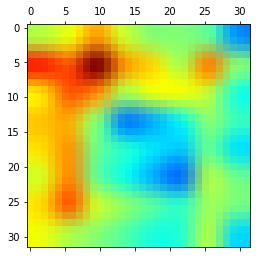

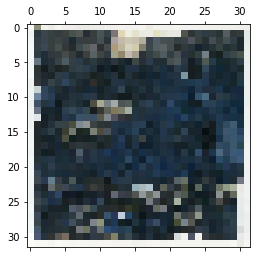

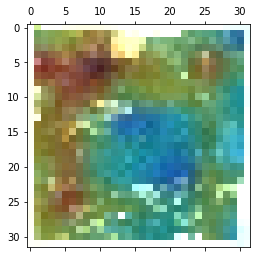

In [ ]:
display_image(img.reshape(32,32,3), heatmap)

# Compute Nearest Neighbors

Generate embeddings

In [ ]:
batch_size = 1
# Get the feature vector representations of the images.
feature_vectors = encoder.predict(dataset_np, batch_size=batch_size, verbose=1)
# Normalize the feature vectores.
feature_vectors = tf.math.l2_normalize(feature_vectors, -1)

341/341 [==============================] - 4s 7ms/step


find k nearest neighbours

In [ ]:
neighbours = []
num_batches = feature_vectors.shape[0] // batch_size
for batch_idx in tqdm(range(num_batches)):
    start_idx = batch_idx * batch_size
    end_idx = start_idx + batch_size
    current_batch = feature_vectors[start_idx:end_idx]
    # Compute the dot similarity.
    similarities = tf.linalg.matmul(current_batch, feature_vectors, transpose_b=True)
    # Get the indices of most similar vectors.
    _, indices = tf.math.top_k(similarities, k=k_neighbours + 1, sorted=True)
    # Add the indices to the neighbours.
    neighbours.append(indices[..., 1:])

neighbours = np.reshape(np.array(neighbours), (-1, k_neighbours))

100%|██████████| 341/341 [00:00<00:00, 1293.97it/s]


In [ ]:
len(neighbours)

341

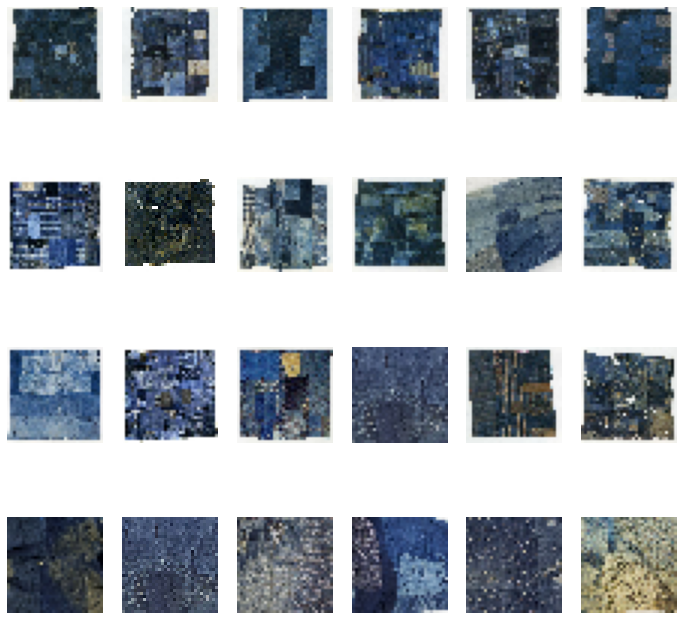

In [ ]:
nrows = 4
ncols = k_neighbours + 1

plt.figure(figsize=(12, 12))
position = 1
for _ in range(nrows):
    anchor_idx = np.random.choice(range(dataset_np.shape[0]))
    neighbour_indicies = neighbours[anchor_idx]
    indices = [anchor_idx] + neighbour_indicies.tolist()
    for j in range(ncols):
        plt.subplot(nrows, ncols, position)
        plt.imshow(dataset_np[indices[j]].astype("uint8"))
        plt.axis("off")
        position += 1

images on each row are supposed to be similar, and they kind of are

# Semantic Clustering

clustering consistency loss: makes sure that neighbours have the same clustering assignments

In [ ]:
class ClustersConsistencyLoss(keras.losses.Loss):
    def __init__(self):
        super(ClustersConsistencyLoss, self).__init__()

    def __call__(self, target, similarity, sample_weight=None):
        # Set targets to be ones.
        target = tf.ones_like(similarity)
        # Compute cross entropy loss.
        loss = keras.losses.binary_crossentropy(
            y_true=target, y_pred=similarity, from_logits=True
        )
        return tf.math.reduce_mean(loss)

cluster entropy loss: makes sure the cluster distribution is uniform

In [ ]:
class ClustersEntropyLoss(keras.losses.Loss):
    def __init__(self, entropy_loss_weight=1.0):
        super(ClustersEntropyLoss, self).__init__()
        self.entropy_loss_weight = entropy_loss_weight

    def __call__(self, target, cluster_probabilities, sample_weight=None):
        # Ideal entropy = log(num_clusters).
        num_clusters = tf.cast(tf.shape(cluster_probabilities)[-1], tf.dtypes.float32)
        target = tf.math.log(num_clusters)
        # Compute the overall clusters distribution.
        cluster_probabilities = tf.math.reduce_mean(cluster_probabilities, axis=0)
        # Replacing zero probabilities - if any - with a very small value.
        cluster_probabilities = tf.clip_by_value(
            cluster_probabilities, clip_value_min=1e-8, clip_value_max=1.0
        )
        # Compute the entropy over the clusters.
        entropy = -tf.math.reduce_sum(
            cluster_probabilities * tf.math.log(cluster_probabilities)
        )
        # Compute the difference between the target and the actual.
        loss = target - entropy
        return loss

In [ ]:
def create_clustering_model(encoder, num_clusters, name=None):
    inputs = keras.Input(shape=input_shape)
    # Preprocess the input images.
    preprocessed = data_preprocessing(inputs)
    # Apply data augmentation to the images.
    augmented = data_augmentation(preprocessed)
    # Generate embedding representations of the images.
    features = encoder(augmented)
    # Assign the images to clusters.
    outputs = layers.Dense(units=num_clusters, activation="softmax")(features)
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    return model

In [ ]:
def create_clustering_learner(clustering_model):
    anchor = keras.Input(shape=input_shape, name="anchors")
    neighbours = keras.Input(
        shape=tuple([k_neighbours]) + input_shape, name="neighbours"
    )
    # Changes neighbours shape to [batch_size * k_neighbours, width, height, channels]
    neighbours_reshaped = tf.reshape(neighbours, shape=tuple([-1]) + input_shape)
    # anchor_clustering shape: [batch_size, num_clusters]
    anchor_clustering = clustering_model(anchor)
    # neighbours_clustering shape: [batch_size * k_neighbours, num_clusters]
    neighbours_clustering = clustering_model(neighbours_reshaped)
    # Convert neighbours_clustering shape to [batch_size, k_neighbours, num_clusters]
    neighbours_clustering = tf.reshape(
        neighbours_clustering,
        shape=(-1, k_neighbours, tf.shape(neighbours_clustering)[-1]),
    )
    # similarity shape: [batch_size, 1, k_neighbours]
    similarity = tf.linalg.einsum(
        "bij,bkj->bik", tf.expand_dims(anchor_clustering, axis=1), neighbours_clustering
    )
    # similarity shape:  [batch_size, k_neighbours]
    similarity = layers.Lambda(lambda x: tf.squeeze(x, axis=1), name="similarity")(
        similarity
    )
    # Create the model.
    model = keras.Model(
        inputs=[anchor, neighbours],
        outputs=[similarity, anchor_clustering],
        name="clustering_learner",
    )
    return model

train the model !

In [ ]:
# If tune_encoder_during_clustering is set to False,
# then freeze the encoder weights.
for layer in encoder.layers:
    layer.trainable = tune_encoder_during_clustering
# Create the clustering model and learner.
clustering_model = create_clustering_model(encoder, num_clusters, name="clustering")
clustering_learner = create_clustering_learner(clustering_model)
# Instantiate the model losses.
losses = [ClustersConsistencyLoss(), ClustersEntropyLoss(entropy_loss_weight=5)]
# Create the model inputs and labels.
inputs = {"anchors": dataset_np, "neighbours": tf.gather(dataset_np, neighbours)}
labels = tf.ones(shape=(dataset_np.shape[0]))
# Compile the model.
clustering_learner.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.0005, weight_decay=0.0001),
    loss=losses,
)

# Begin training the model.
clustering_learner.fit(x=inputs, y=labels, batch_size=16, epochs=50)

Epoch 1/50
22/22 [==============================] - 10s 75ms/step - loss: 0.6841 - similarity_loss: 0.6665 - clustering_loss: 0.0175
Epoch 2/50
22/22 [==============================] - 1s 29ms/step - loss: 0.6762 - similarity_loss: 0.6681 - clustering_loss: 0.0081
Epoch 3/50
22/22 [==============================] - 1s 38ms/step - loss: 0.6740 - similarity_loss: 0.6682 - clustering_loss: 0.0058
Epoch 4/50
22/22 [==============================] - 1s 35ms/step - loss: 0.6822 - similarity_loss: 0.6672 - clustering_loss: 0.0150
Epoch 5/50
22/22 [==============================] - 1s 48ms/step - loss: 0.6799 - similarity_loss: 0.6662 - clustering_loss: 0.0137
Epoch 6/50
22/22 [==============================] - 1s 30ms/step - loss: 0.6779 - similarity_loss: 0.6674 - clustering_loss: 0.0105
Epoch 7/50
22/22 [==============================] - 1s 29ms/step - loss: 0.6734 - similarity_loss: 0.6671 - clustering_loss: 0.0063
Epoch 8/50
22/22 [==============================] - 1s 29ms/step - loss: 0.

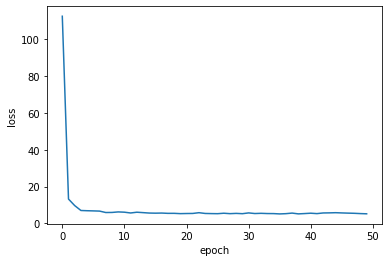

In [ ]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

# Analysis

In [ ]:
# Get the cluster probability distribution of the input images.
clustering_probs = clustering_model.predict(dataset_np, batch_size=batch_size, verbose=1)
# Get the cluster of the highest probability.
cluster_assignments = tf.math.argmax(clustering_probs, axis=-1).numpy()
# Store the clustering confidence.
# Images with the highest clustering confidence are considered the 'prototypes'
# of the clusters.
cluster_confidence = tf.math.reduce_max(clustering_probs, axis=-1).numpy()

341/341 [==============================] - 3s 8ms/step


Compute cluster sizes

In [ ]:
clusters = defaultdict(list)
for idx, c in enumerate(cluster_assignments):
    clusters[c].append((idx, cluster_confidence[idx]))

for c in range(num_clusters):
    print("cluster", c, ":", len(clusters[c]))

cluster 0 : 15
cluster 1 : 22
cluster 2 : 18
cluster 3 : 16
cluster 4 : 2
cluster 5 : 23
cluster 6 : 11
cluster 7 : 34
cluster 8 : 14
cluster 9 : 31
cluster 10 : 9
cluster 11 : 22
cluster 12 : 14
cluster 13 : 20
cluster 14 : 16
cluster 15 : 12
cluster 16 : 6
cluster 17 : 37
cluster 18 : 8
cluster 19 : 11


# Visualize Images with high confidence

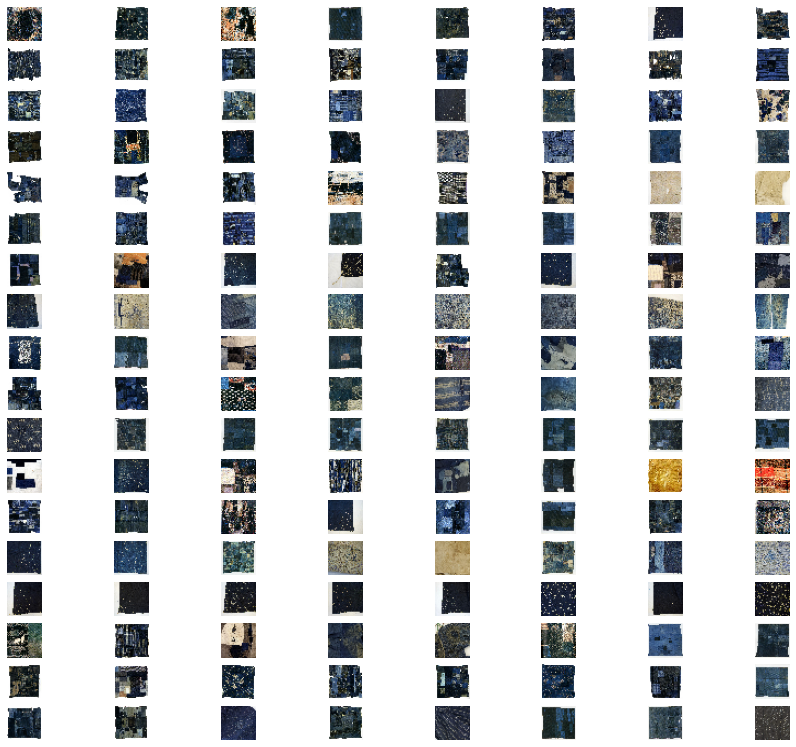

In [ ]:
num_images = 8
plt.figure(figsize=(15, 15))
position = 1


for c in range(num_clusters):
    cluster_instances = sorted(clusters[c], key=lambda kv: kv[1], reverse=True)
    if len(cluster_instances) < num_images:
        continue
    
    for j in range(num_images):
        image_idx = cluster_instances[j][0]
        plt.subplot(num_clusters, num_images, position)
        plt.imshow(dataset_np[image_idx].astype("uint8"))
        # plt.title(classes[y_data[image_idx][0]])
        plt.axis("off")
        position += 1

Plot each cluster

In [ ]:
def plot_cluster_images(cluster_no):
    # tile = (8,8)
    
    # cluster_no = 6

    cluster_instances = sorted(clusters[cluster_no], key=lambda kv: kv[1], reverse=True)
    x = 6
    y = len(cluster_instances) // x + 1
    plt.figure(figsize=(15, y*2))

    for i, d in enumerate(cluster_instances):
        image_idx = d[0]
        plt.subplot(y, x, i+1)
        plt.imshow(dataset_np[image_idx].astype("uint8"))
        # plt.title(classes[y_data[image_idx][0]])
        plt.axis("off")

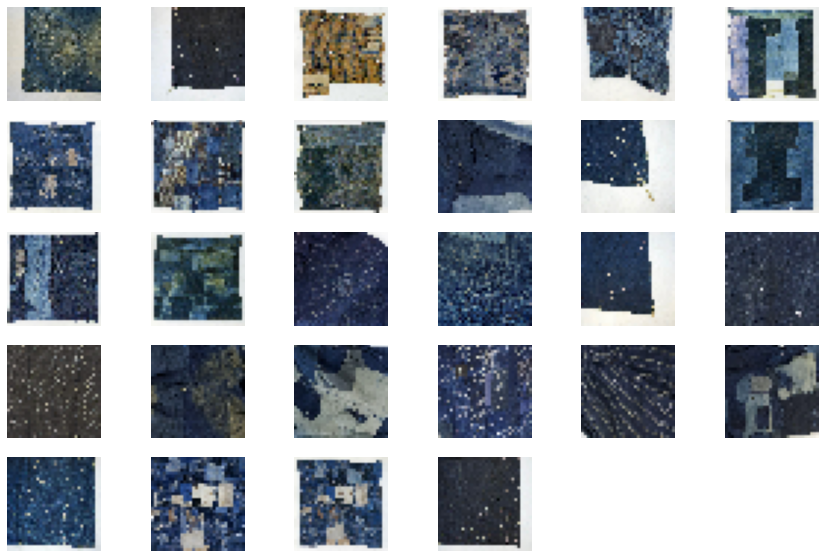

In [ ]:
plot_cluster_images(0)

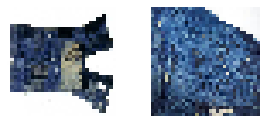

In [ ]:
plot_cluster_images(1)

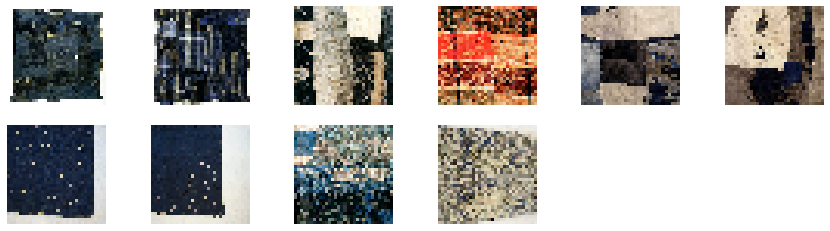

In [ ]:
plot_cluster_images(2)

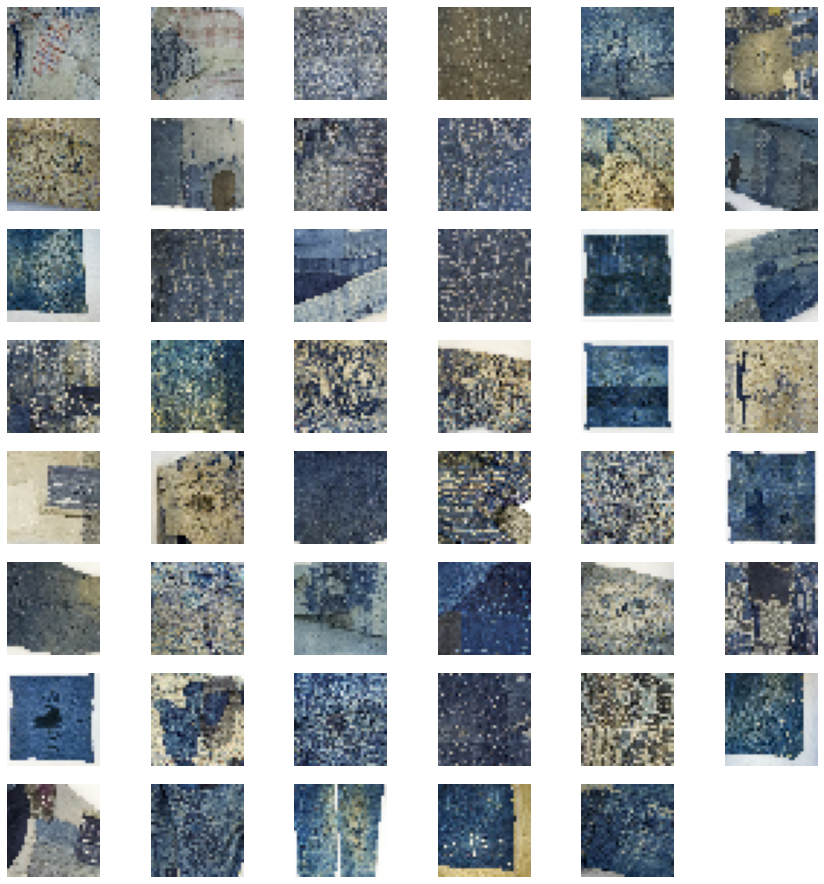

In [ ]:
plot_cluster_images(3)

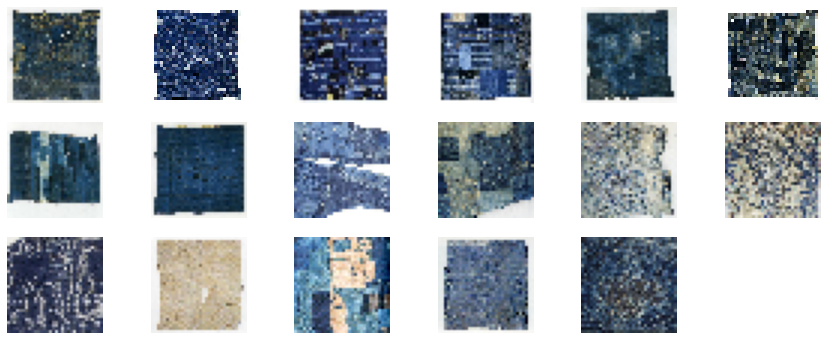

In [ ]:
plot_cluster_images(4)

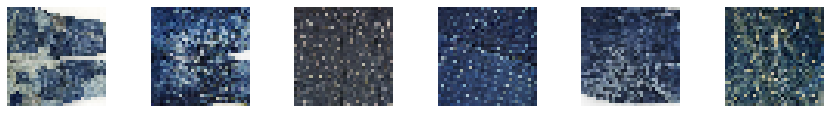

In [ ]:
plot_cluster_images(5)

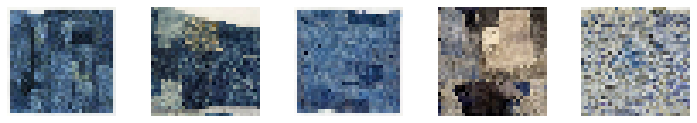

In [ ]:
plot_cluster_images(6)

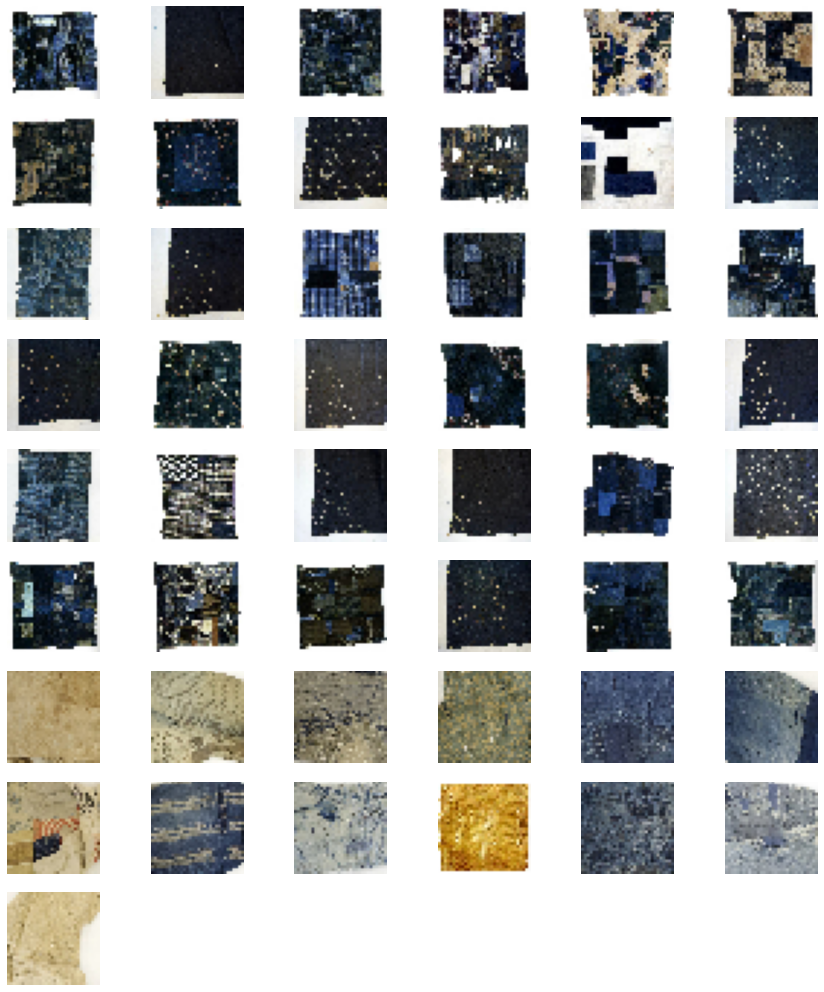

In [ ]:
plot_cluster_images(7)

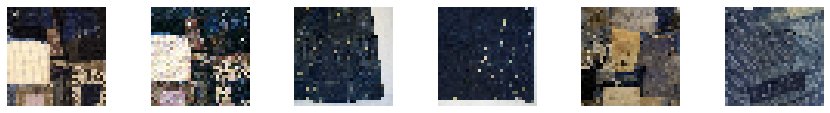

In [ ]:
plot_cluster_images(8)

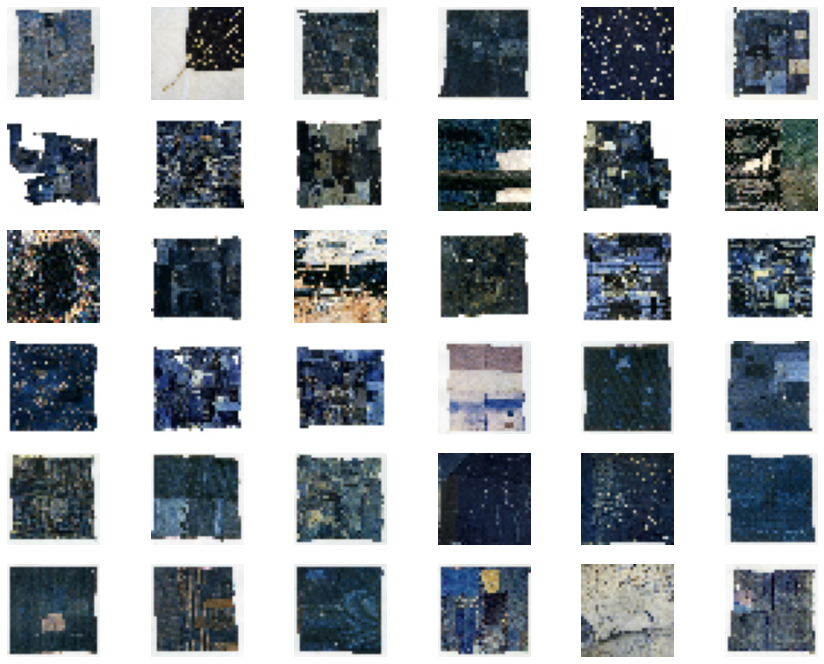

In [ ]:
plot_cluster_images(9)

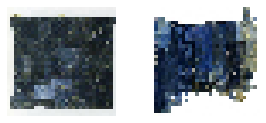

In [ ]:
plot_cluster_images(10)

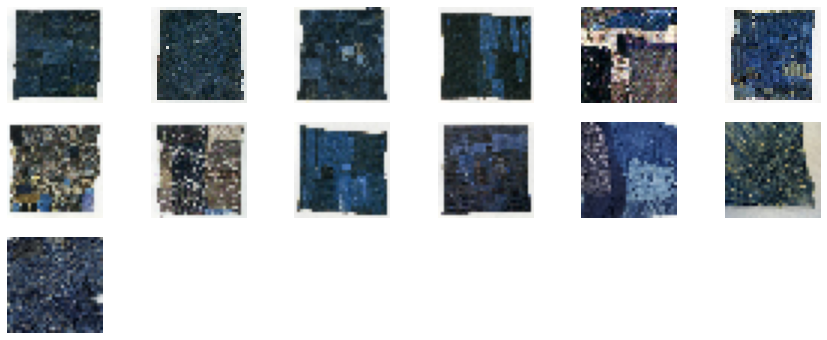

In [ ]:
plot_cluster_images(11)

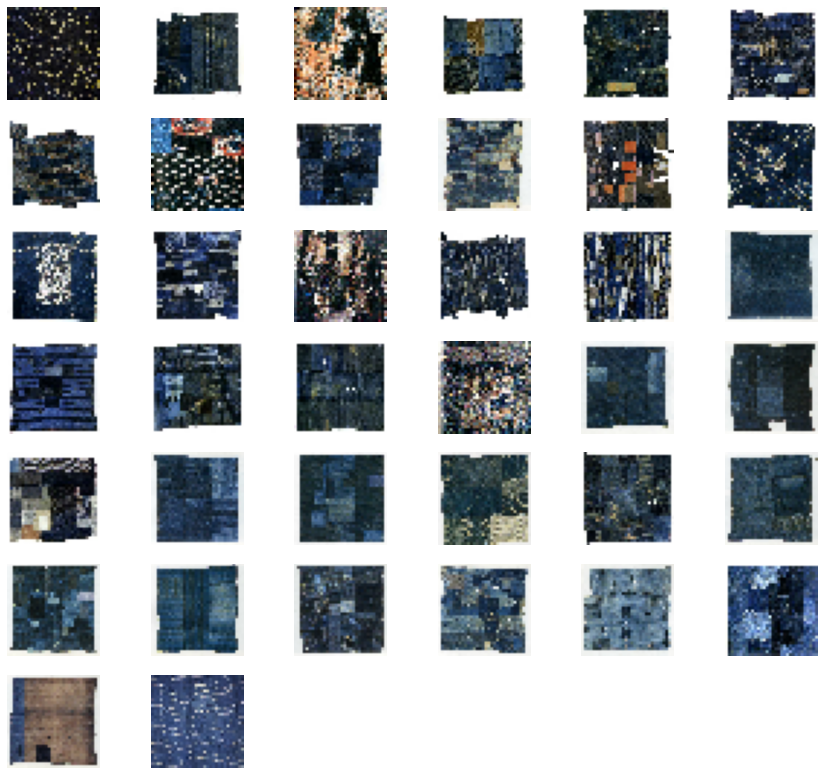

In [ ]:
plot_cluster_images(12)

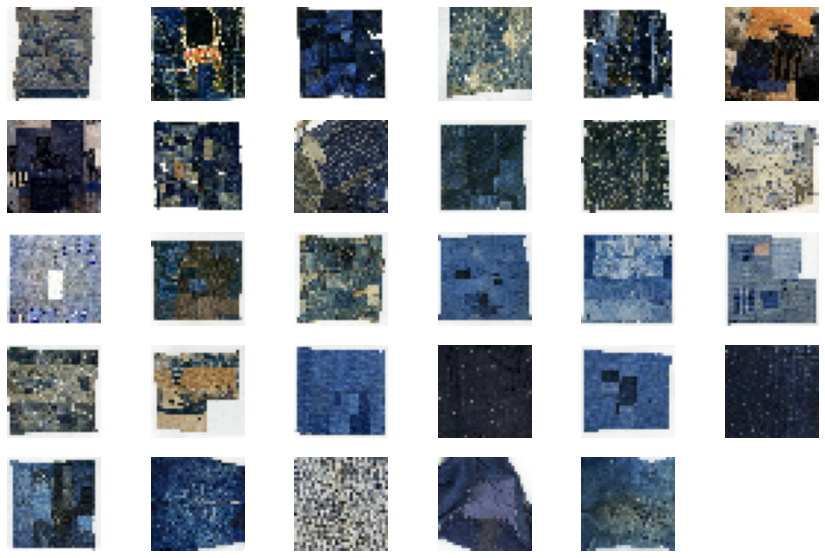

In [ ]:
plot_cluster_images(13)

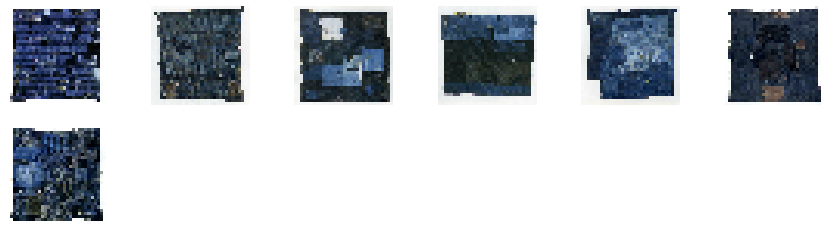

In [ ]:
plot_cluster_images(14)

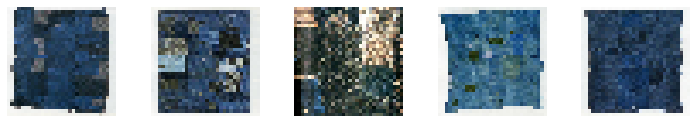

In [ ]:
plot_cluster_images(15)

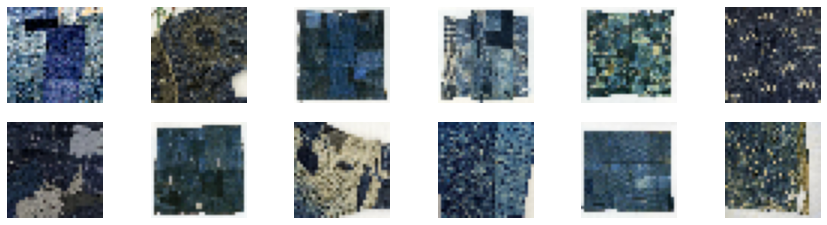

In [ ]:
plot_cluster_images(16)

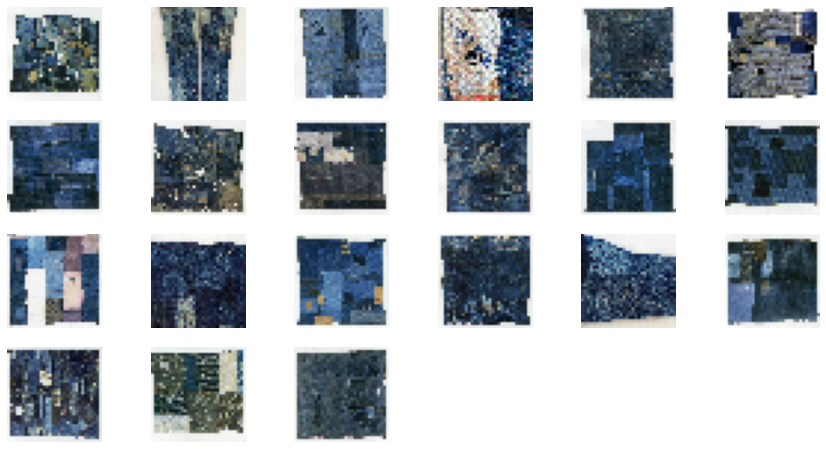

In [ ]:
plot_cluster_images(17)

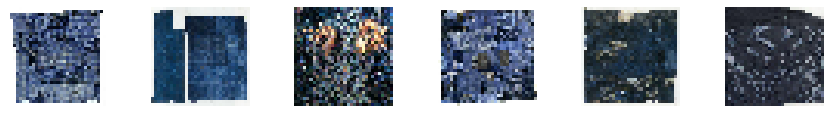

In [ ]:
plot_cluster_images(18)

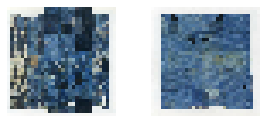

In [ ]:
plot_cluster_images(19)